In [1]:
# !pip install ydata_profiling

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from scipy.stats import zscore
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
%matplotlib inline

In [2]:
# Loading the data with column names
df = pd.read_csv(
    "vertebral_column_data.txt",
    delimiter=" ",
    header=None,
    names=[
        'pelvic_incidence',
        'pelvic_tilt',
        'lumbar_lordosis_angle',
        'sacral_slope',
        'pelvic_radius',
        'grade_of_spondylolisthesis',
        'class'
    ]
)

# Verifying the first 5 rows
df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,grade_of_spondylolisthesis,class
0,63.03,22.55,39.61,40.48,98.67,-0.25,AB
1,39.06,10.06,25.02,29.00,114.41,4.56,AB
2,68.83,22.22,50.09,46.61,105.99,-3.53,AB
3,69.30,24.65,44.31,44.64,101.87,11.21,AB
4,49.71,9.65,28.32,40.06,108.17,7.92,AB


# EDA

In [3]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title='EDA Report')
profile.to_file('eda_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

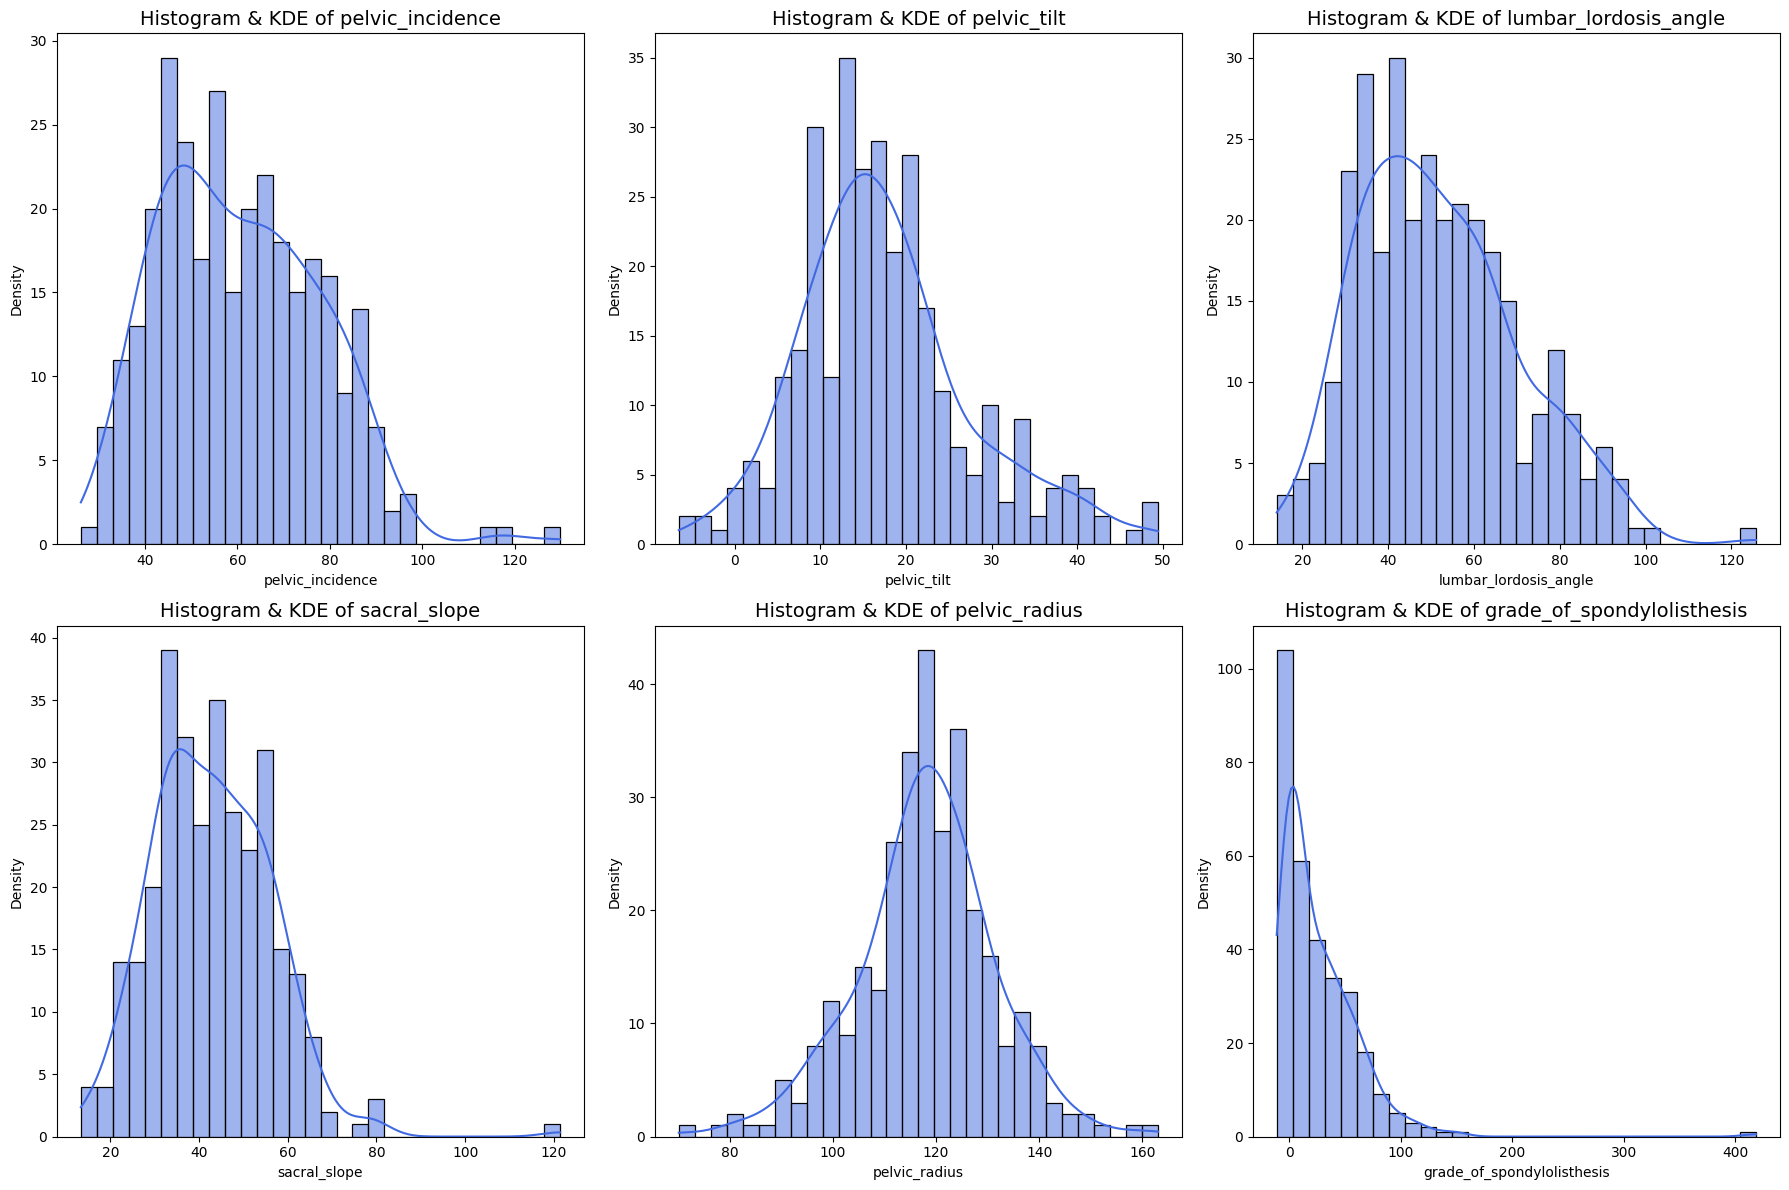

In [4]:
num_vars = df.columns[:-1]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axes = axes.flatten()

for i, var in enumerate(num_vars):
    sns.histplot(df[var], kde=True, ax=axes[i], bins=30, color='royalblue')
    axes[i].set_title(f"Histogram & KDE of {var}", fontsize=14)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel("Density")

plt.tight_layout()
plt.show()

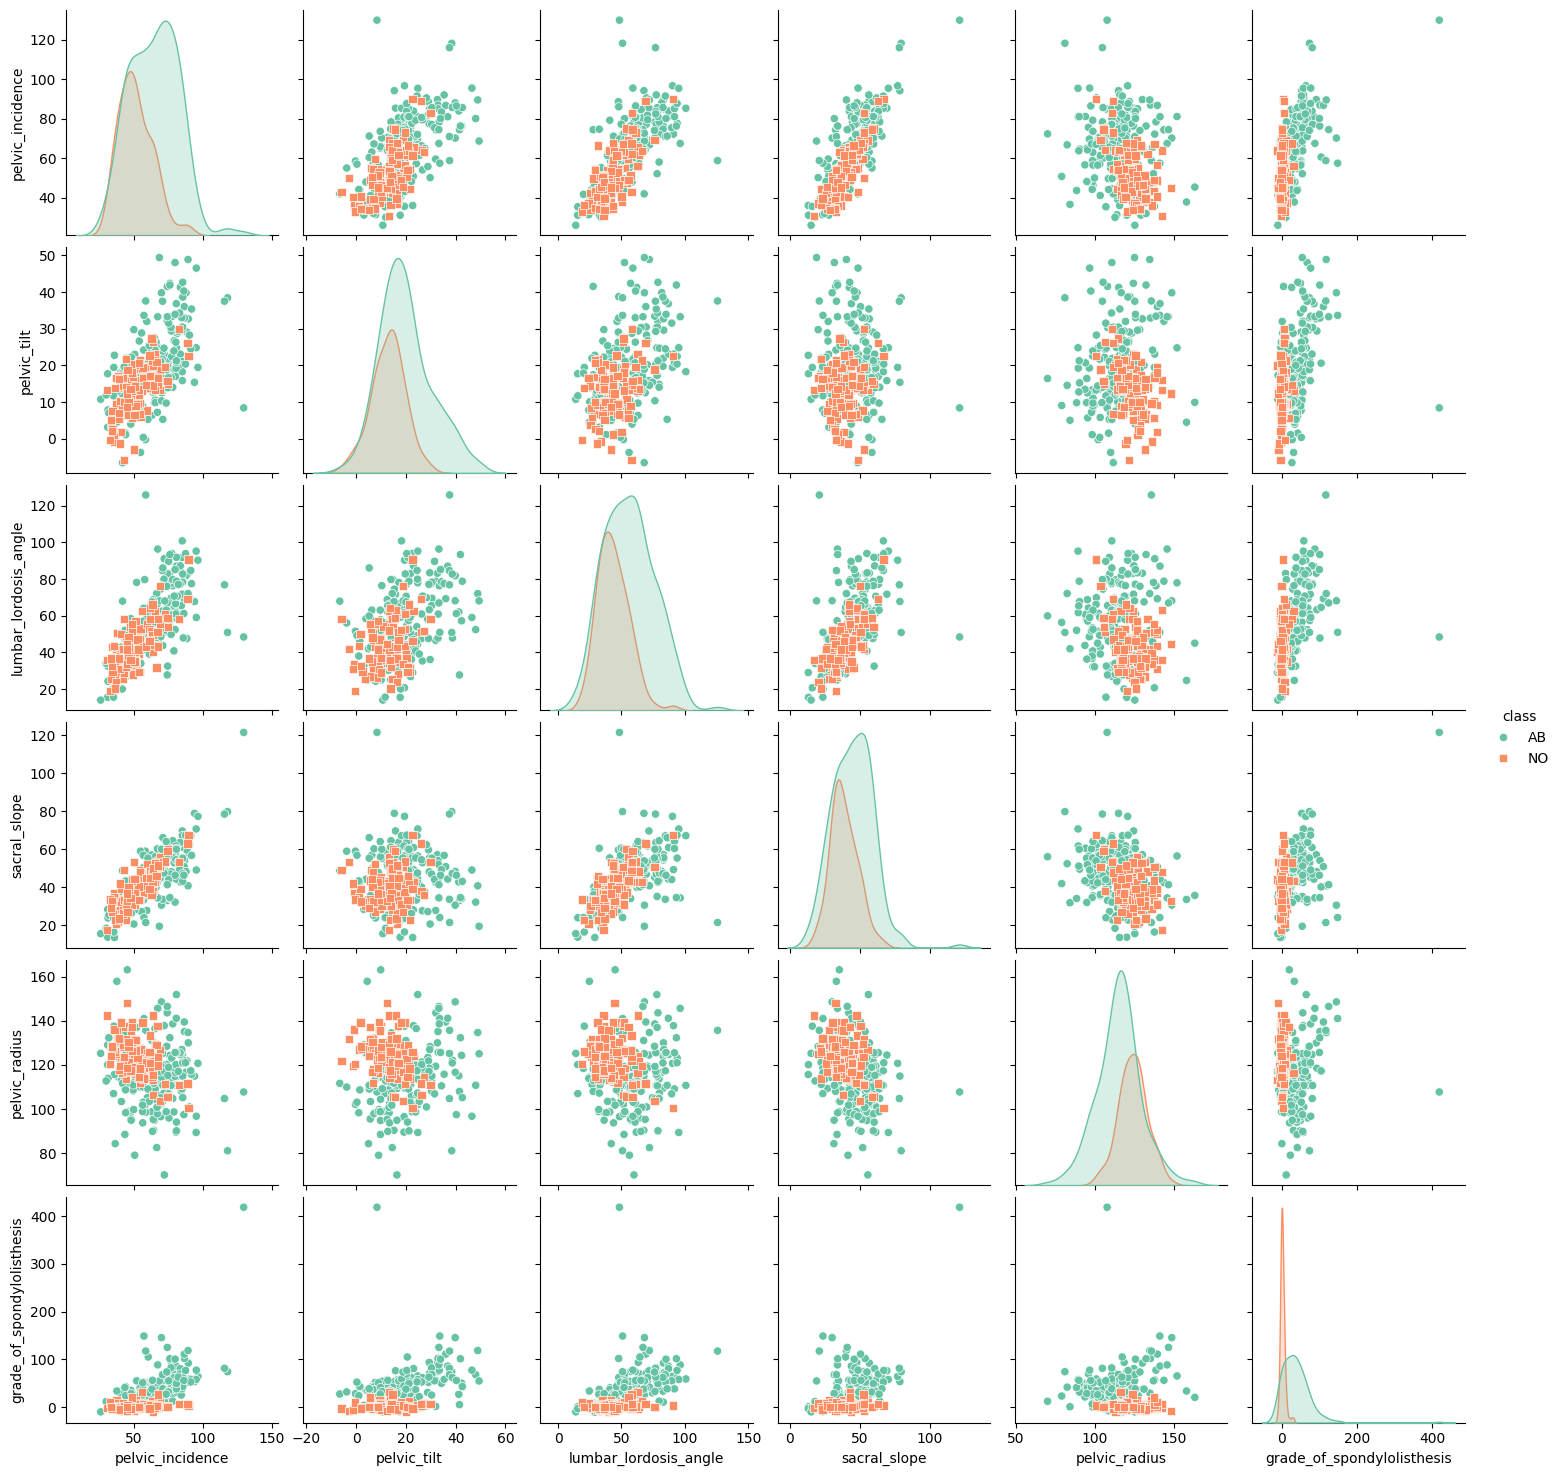

In [5]:
pairplot_fig = sns.pairplot(df, hue="class", palette="Set2", diag_kind="kde", markers=["o", "s"])
plt.show()

# Unsupervised Classification

In [6]:
# PCA & GMM

# data preprocessing（drop the empty columns）

df = df.dropna(axis=1, how='all')
print("\nA sample form the Dataset:")
print(df.head())

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

print("\nChecking outliers（Z-score > 3 :")
z_scores = np.abs(zscore(X))
print((z_scores > 3).sum())


A sample form the Dataset:
   pelvic_incidence  pelvic_tilt  lumbar_lordosis_angle  sacral_slope  \
0             63.03        22.55                  39.61         40.48   
1             39.06        10.06                  25.02         29.00   
2             68.83        22.22                  50.09         46.61   
3             69.30        24.65                  44.31         44.64   
4             49.71         9.65                  28.32         40.06   

   pelvic_radius  grade_of_spondylolisthesis class  
0          98.67                       -0.25    AB  
1         114.41                        4.56    AB  
2         105.99                       -3.53    AB  
3         101.87                       11.21    AB  
4         108.17                        7.92    AB  

Checking outliers（Z-score > 3 :
pelvic_incidence              3
pelvic_tilt                   3
lumbar_lordosis_angle         1
sacral_slope                  1
pelvic_radius                 3
grade_of_spondylolisth

In [7]:
# data cleaning method1

Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_cleaned = X.copy()
for col in X.columns:
    median_value = X[col].median()
    df_cleaned[col] = X[col].mask((X[col] < lower_bound[col]) | (X[col] > upper_bound[col]), median_value)

# replacing the outliers with medians

for col in X.columns:
    median_value = X[col].median()
    df[col] = X[col].mask((X[col] < lower_bound[col]) | (X[col] > upper_bound[col]), median_value)

z_scores_after = np.abs(zscore(df_cleaned))
print("\nChecking outliers after cleaning (Z-score > 3):")
print((z_scores_after > 3).sum())


Checking outliers after cleaning (Z-score > 3):
pelvic_incidence              0
pelvic_tilt                   0
lumbar_lordosis_angle         0
sacral_slope                  0
pelvic_radius                 0
grade_of_spondylolisthesis    1
dtype: int64


In [8]:
# method2(because there is still one outlier after method1)

z_scores = np.abs(zscore(df.iloc[:, :-1]))
outliers = z_scores > 3
for col in X.columns:
    median_value = X[col].median()
    df.loc[outliers[col], col] = median_value

print("\nChecking outliers after cleaning（Z-score > 3）：")
X_cleaned = df.iloc[:, :-1]
z_scores_after = np.abs(zscore(X_cleaned))
print((z_scores_after > 3).sum())


Checking outliers after cleaning（Z-score > 3）：
pelvic_incidence              0
pelvic_tilt                   0
lumbar_lordosis_angle         0
sacral_slope                  0
pelvic_radius                 0
grade_of_spondylolisthesis    0
dtype: int64



Dataset after normalization:
   pelvic_incidence  pelvic_tilt  lumbar_lordosis_angle  sacral_slope  \
0          0.169452     0.600242              -0.379261     -0.099726   
1         -0.756835    -0.610909              -0.941171     -0.699909   
2          0.393585     0.568242               0.024360      0.220755   
3          0.411748     0.803879              -0.198248      0.117762   
4         -0.345281    -0.650667              -0.814077     -0.121683   

   pelvic_radius  grade_of_spondylolisthesis  class  
0      -1.409712                   -0.326678      1  
1      -0.277338                   -0.194217      1  
2      -0.883094                   -0.417005      1  
3      -1.179496                   -0.011084      1  
4      -0.726259                   -0.101687      1  

Correlation Matrix: 


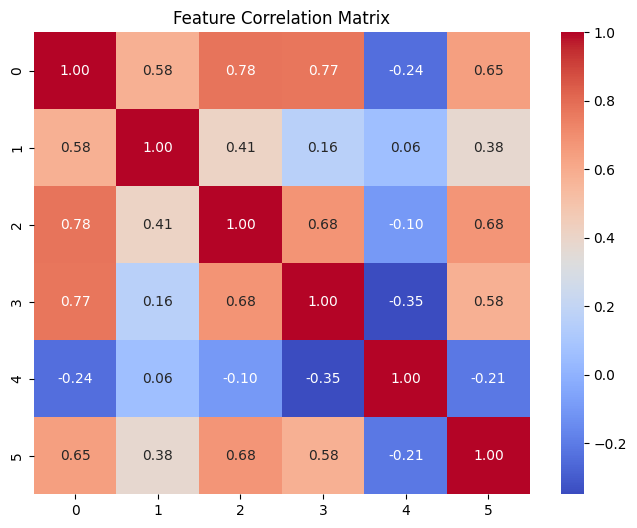

In [9]:
# normalization
# scaler = StandardScaler()

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_cleaned)

# dummy
y_mapped = y.map({'NO': 0, 'AB': 1})

df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
df_scaled['class'] = y_mapped
print("\nDataset after normalization:")
print(df_scaled.head())

print("\nCorrelation Matrix: ")
corr_matrix = pd.DataFrame(X_scaled).corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

Cumulative variance:  [0.51432739 0.75096711 0.88584195 0.94918116 0.98594637 1.        ]
selected dimensions 5


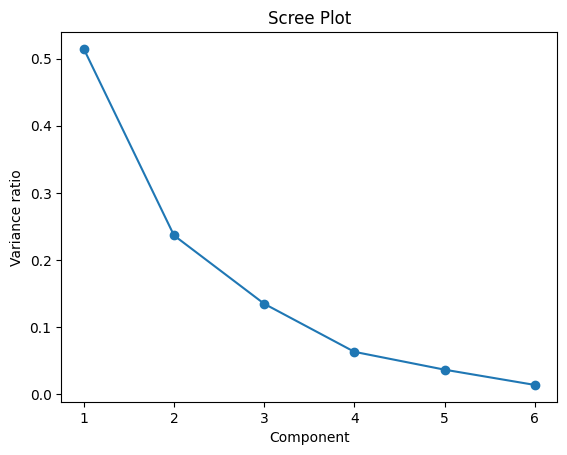

In [10]:
pca = PCA()
pca.fit(X_scaled)

# get the variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# calculate the cumulative variance
cumulative_variance = np.cumsum(explained_variance_ratio)

print("Cumulative variance: ", cumulative_variance)

# Determining the dimensions after dimensionality reduction and selecting the principal components that explain 95% of the variance
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"selected dimensions {n_components}")

plt.plot(np.arange(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.title('Scree Plot')
plt.xlabel('Component')
plt.ylabel('Variance ratio')
plt.show()

In [11]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

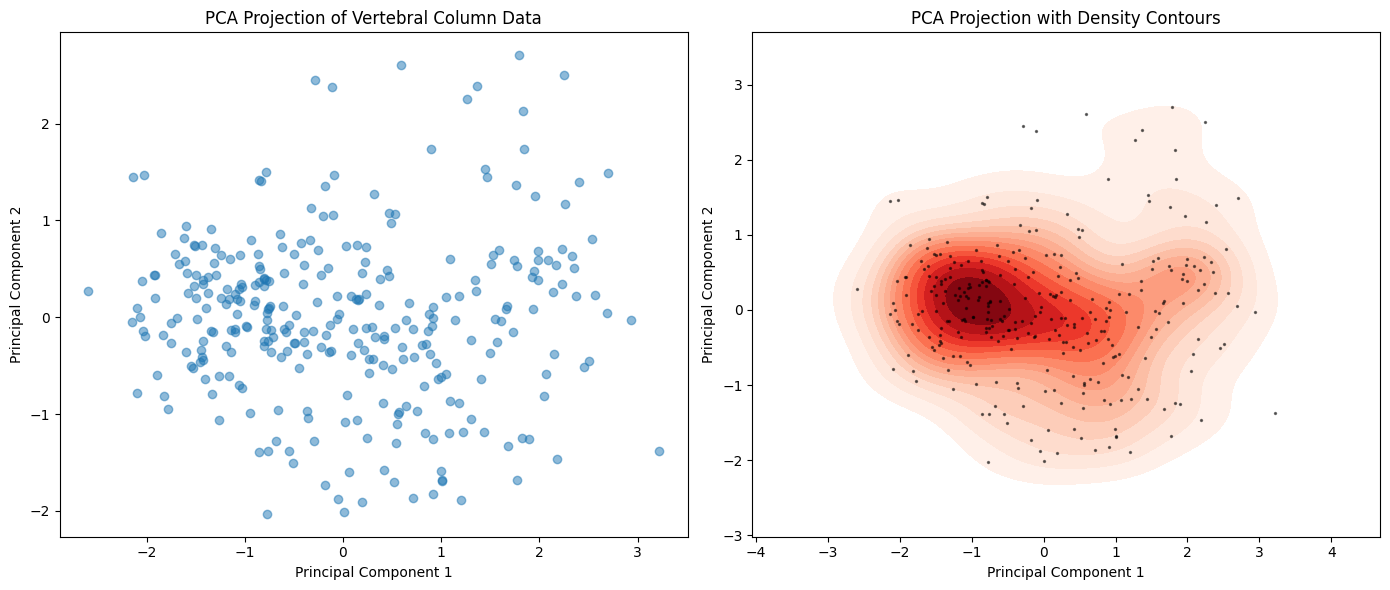

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
axes[0].set_xlabel("Principal Component 1")
axes[0].set_ylabel("Principal Component 2")
axes[0].set_title("PCA Projection of Vertebral Column Data")

sns.kdeplot(x=X_pca[:, 0], y=X_pca[:, 1], fill=True, cmap="Reds", levels=15, ax=axes[1])
axes[1].scatter(X_pca[:, 0], X_pca[:, 1], s=2, color="black", alpha=0.5)
axes[1].set_xlabel("Principal Component 1")
axes[1].set_ylabel("Principal Component 2")
axes[1].set_title("PCA Projection with Density Contours")

plt.tight_layout()
plt.show()

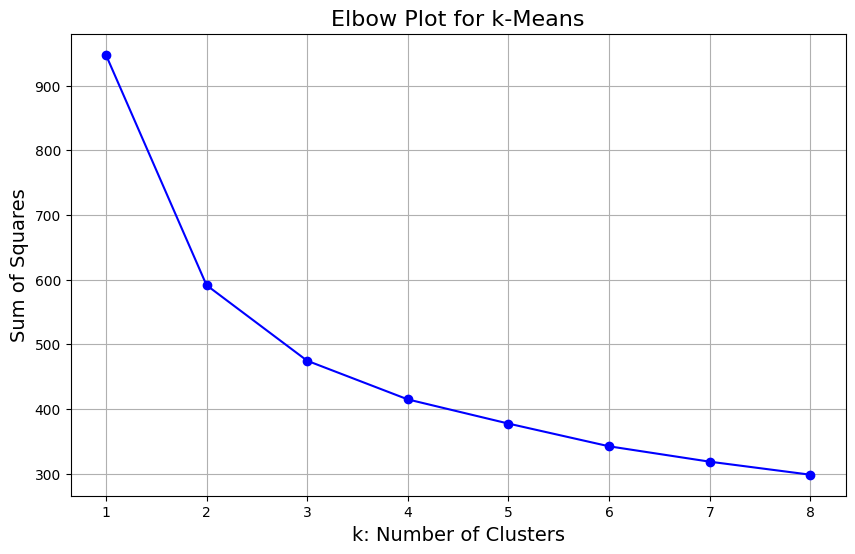


Cluster Centers (after scaling):
 [[-1.07183781  0.22212112  0.01001131 -0.00311036 -0.01013479]
 [ 1.81093445  0.71136181 -0.14842773  0.11741661 -0.03182569]
 [ 0.51261221 -0.69056064  0.06593131 -0.05882569  0.03116867]]


In [13]:
from sklearn.cluster import KMeans

kMin, kMax = 1, 8
repsPerK = 10
kValues = np.arange(kMin, kMax + 1)
sumOfSquares = np.zeros(len(kValues))

for i, k in enumerate(kValues):
    kmeans = KMeans(n_clusters=k, n_init=repsPerK, random_state=42).fit(X_pca)
    sumOfSquares[i] = kmeans.inertia_

# The elbow plot
plt.figure(figsize=(10, 6))
plt.plot(kValues, sumOfSquares, marker='o', linestyle='-', color='b')
plt.xlabel("k: Number of Clusters", fontsize=14)
plt.ylabel("Sum of Squares", fontsize=14)
plt.title("Elbow Plot for k-Means", fontsize=16)
plt.xticks(kValues)
plt.grid(True)
plt.show()

optimal_k = 3
kmeans_final = KMeans(n_clusters=optimal_k, n_init=10, random_state=42).fit(X_pca)
y_pred = kmeans_final.labels_

print("\nCluster Centers (after scaling):\n", kmeans_final.cluster_centers_)

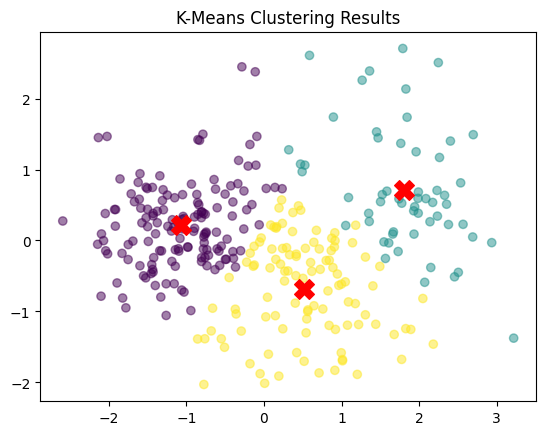

In [14]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_final.labels_, cmap='viridis', alpha=0.5)
plt.scatter(kmeans_final.cluster_centers_[:, 0], kmeans_final.cluster_centers_[:, 1], c='red', marker='X', s=200)
plt.title("K-Means Clustering Results")
plt.show()

In [15]:
from sklearn.metrics import adjusted_rand_score, silhouette_score

ari1 = adjusted_rand_score(y, y_pred)
print(f"Adjusted Rand Index (ARI): {ari1:.4f}")

silhouette1 = silhouette_score(X_pca, y_pred)
print(f"Silhouette Score: {silhouette1:.4f}")

Adjusted Rand Index (ARI): 0.0766
Silhouette Score: 0.2866


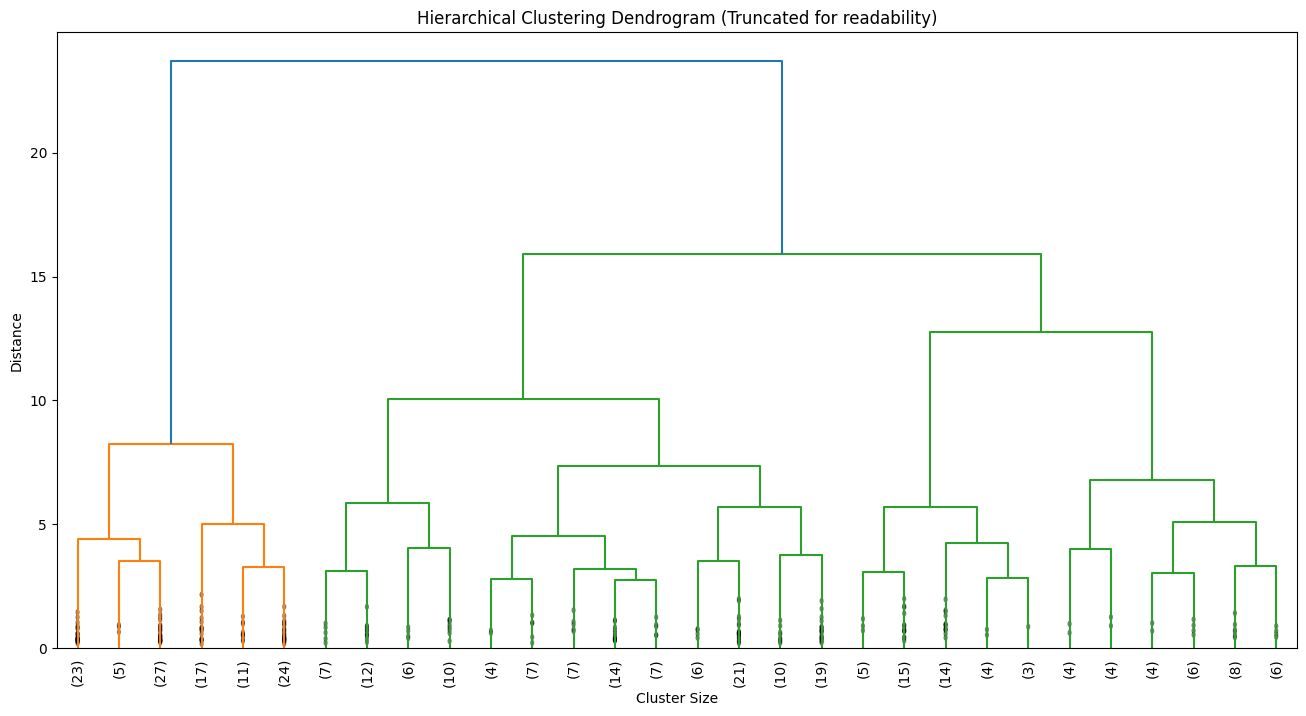

In [16]:
# Hierarchical Clustering

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

# Calculating the distance matrix
distance_matrix = pdist(X_pca, metric='euclidean')

# Performing hierarchical clustering
Z = linkage(distance_matrix, method='ward')

# Plotting the dendrogram
plt.figure(figsize=(16, 8))
dendrogram(
    Z,
    truncate_mode='lastp',
    p=30,  # Number of clusters to show
    leaf_rotation=90.,  # Rotating labels for readability
    leaf_font_size=10.,
    show_contracted=True,
)

plt.title("Hierarchical Clustering Dendrogram (Truncated for readability)")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.show()

In [17]:
from scipy.cluster.hierarchy import fcluster

num_clusters = 2
clusters = fcluster(Z, num_clusters, criterion='maxclust')
clusters -= 1

In [18]:
ari2 = adjusted_rand_score(y, clusters)
silhouette2 = silhouette_score(X_pca, clusters)

print(f"Adjusted Rand Index (ARI): {ari2:.4f}")
print(f"Silhouette Score: {silhouette2:.4f}")

Adjusted Rand Index (ARI): 0.1692
Silhouette Score: 0.2434


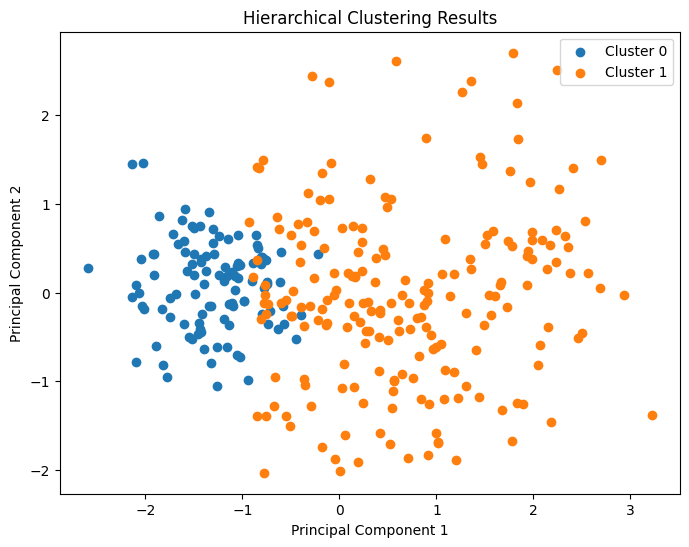

In [19]:
plt.figure(figsize=(8, 6))
for cluster in range(num_clusters):
    plt.scatter(X_pca[clusters == cluster, 0], X_pca[clusters == cluster, 1], label=f"Cluster {cluster}")

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Hierarchical Clustering Results")
plt.legend()
plt.show()

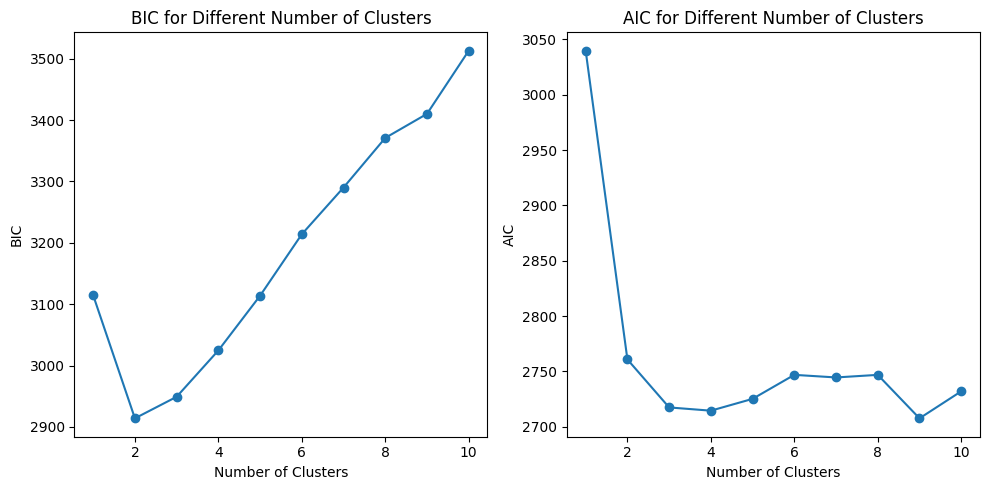


According to BIC，the optimal cluster: 2
According to AIC，the optimal cluster: 9


In [20]:
# Model-based GMM

from sklearn.mixture import GaussianMixture

# Trying different clusters and calculating BIC or AIC
bic_scores = []
aic_scores = []
clusters_range = range(1, 11)

for n_clusters in clusters_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(X_pca)
    bic_scores.append(gmm.bic(X_pca))
    aic_scores.append(gmm.aic(X_pca))

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(clusters_range, bic_scores, marker='o')
plt.title('BIC for Different Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC')

plt.subplot(1, 2, 2)
plt.plot(clusters_range, aic_scores, marker='o')
plt.title('AIC for Different Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('AIC')

plt.tight_layout()
plt.show()

optimal_clusters_bic = clusters_range[np.argmin(bic_scores)]
optimal_clusters_aic = clusters_range[np.argmin(aic_scores)]

print(f"\nAccording to BIC，the optimal cluster: {optimal_clusters_bic}")
print(f"According to AIC，the optimal cluster: {optimal_clusters_aic}")

In [21]:
for cov_type in ['full', 'tied', 'diag', 'spherical']:
    gmm = GaussianMixture(n_components=3, covariance_type=cov_type, random_state=42)
    gmm.fit(X_pca)
    print(f"Covariance Type: {cov_type}, BIC: {gmm.bic(X_pca)}, AIC: {gmm.aic(X_pca)}")

Covariance Type: full, BIC: 2949.1948478572754, AIC: 2717.5273654135653
Covariance Type: tied, BIC: 3052.950816716747, AIC: 2933.3805031974125
Covariance Type: diag, BIC: 2981.292682560128, AIC: 2861.7223690407936
Covariance Type: spherical, BIC: 3221.7664841805963, AIC: 3147.0350382310125


Initialization 0
  Iteration 10	 time lapse 0.00854s	 ll change 0.00057
Initialization converged. time lapse 0.00861s	 lower bound -4.32100.


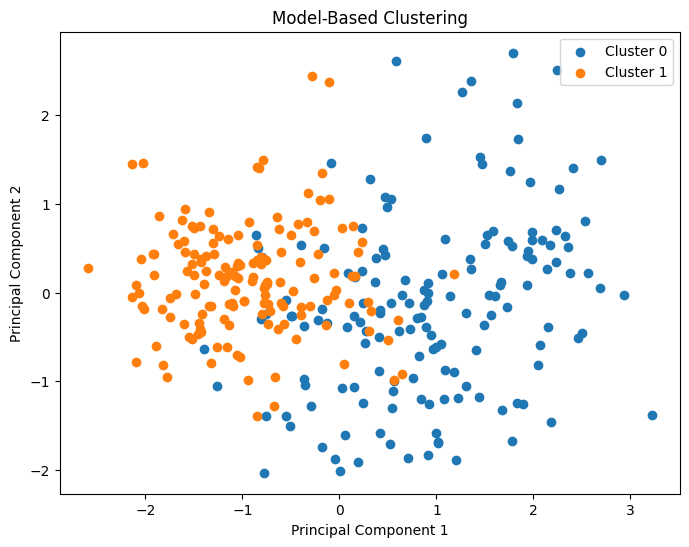

In [22]:
from sklearn.decomposition import PCA

num_clusters = 2  # Can be adjusted(according to BIC&AIC)
gmm = GaussianMixture(n_components=num_clusters, covariance_type="full",  random_state=42, verbose=2)
clusters = gmm.fit_predict(X_pca)

plt.figure(figsize=(8, 6))
for cluster in range(num_clusters):
    plt.scatter(X_pca[clusters == cluster, 0], X_pca[clusters == cluster, 1], label=f"Cluster {cluster}")

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Model-Based Clustering")
plt.legend()
plt.show()


In [23]:
# calculate ARI
ari3 = adjusted_rand_score(y, clusters)
print(f"Adjusted Rand Index (ARI): {ari3:.4f}")

# calculate Silhouette Score
silhouette3 = silhouette_score(X_pca, clusters)
print(f"Silhouette Score: {silhouette3:.4f}")

Adjusted Rand Index (ARI): 0.2987
Silhouette Score: 0.2715


# Supervised Classification

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [25]:
df_scaled.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,grade_of_spondylolisthesis,class
0,0.169452,0.600242,-0.379261,-0.099726,-1.409712,-0.326678,1
1,-0.756835,-0.610909,-0.941171,-0.699909,-0.277338,-0.194217,1
2,0.393585,0.568242,0.024360,0.220755,-0.883094,-0.417005,1
3,0.411748,0.803879,-0.198248,0.117762,-1.179496,-0.011084,1
4,-0.345281,-0.650667,-0.814077,-0.121683,-0.726259,-0.101687,1


The dataset contains only 6 features, which is a small number and can be handled effectively without the need for dimensionality reduction. Moreover, the features have clear physical interpretations and play a significant role in the model's performance, as evident from the Feature Importance Graph.

As an experiment, PCA was applied towards the end of the analysis, but it resulted in lower accuracy. This suggests that dimensionality reduction may not improve accuracy significantly and could also reduce the interpretability of the model.

In [26]:
# Features and target
X = df_scaled.drop(columns=["class"])
y = df_scaled["class"]

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing a Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the model
rf_clf.fit(X_train, y_train)

# Making predictions
y_pred = rf_clf.predict(X_test)

print("\nPredictions made by the RandomForestClassifier: ")
print(y_pred)


Predictions made by the RandomForestClassifier: 
[0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1
 0 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1]


Accuracy: 0.79

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.56      0.61        18
           1       0.83      0.89      0.86        44

    accuracy                           0.79        62
   macro avg       0.75      0.72      0.73        62
weighted avg       0.78      0.79      0.78        62



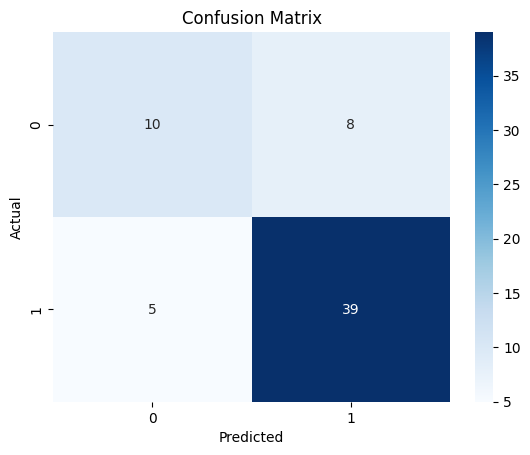

In [27]:
# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# The Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The model performs well on class 1 but struggles with class 0, likely due to class imbalance. Addressing this imbalance could improve performance.

* Accuracy: 0.79: The model correctly predicts 79% of the test samples.

* Class 0: Precision (67%), Recall (56%), F1-score (61%). The model struggles with class 0, missing 44% of its samples.

* Class 1: Precision (83%), Recall (89%), F1-score (86%). The model performs well on class 1.

* Macro Avg: Moderate overall performance (precision: 0.75, recall: 0.72, F1-score: 0.73).

* Weighted Avg: Slightly better (precision: 0.78, recall: 0.79, F1-score: 0.78) due to class imbalance favoring class 1.





In [28]:
df_scaled['class'].value_counts()

,count
class,
1,210
0,100


The class imbalanced is clearly visible.

In [29]:
from imblearn.under_sampling import RandomUnderSampler

# Applying RandomUnderSampler to balance the classes
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)

Accuracy: 0.93

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           1       0.90      0.95      0.92        19

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.93      0.93      0.93        40



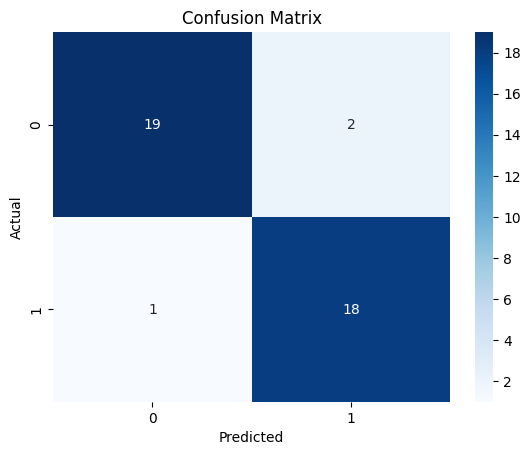

In [30]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The model performs well on both classes after undersampling, with high accuracy and balanced metrics. Addressing the class imbalance improved overall performance.

* Accuracy: 0.93**: The model correctly predicts 93% of test samples.
- Class 0: Precision (95%), Recall (90%), F1-score (93%). Strong performance.
- Class 1: Precision (90%), Recall (95%), F1-score (92%). Strong performance.
- Macro Avg: Consistent performance across classes (precision: 0.93, recall: 0.93, F1-score: 0.92).
- Weighted Avg: Similar to macro averages due to balanced classes.


**Creating a Feature Importance graph**

In [31]:
feature_importances = rf_clf.feature_importances_
feature_names = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle',
                 'sacral_slope', 'pelvic_radius', 'grade_of_spondylolisthesis']

# Sorting the features by importance
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_features = np.array(feature_names)[sorted_idx]
sorted_importances = feature_importances[sorted_idx]

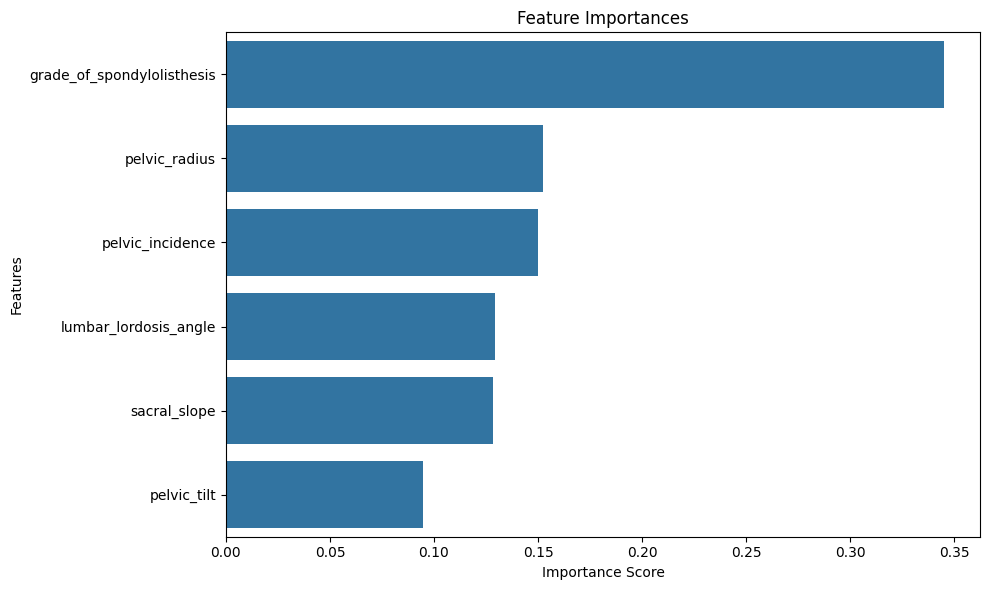

In [32]:
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importances, y=sorted_features)
plt.title("Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

The feature importance graph shows that `grade_of_spondylolisthesis` is the most critical feature, making it a key focus for model improvement and analysis. Features like `pelvic_radius` and `pelvic_tilt` also contribute significantly, while `sacral_slope` and `lumbar_lordosis_angle` hold less importance. This insight can help refine the model by prioritizing impactful features and potentially reducing less influential ones.

**Finding the best hyperparameters**

In [33]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [34]:
# Initialize Random Forest Classifier with the best hyperparameters
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=1,
    random_state=42
)

# Train the model
rf_clf.fit(X_train, y_train)

# Make predictions
y_pred = rf_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Full Feature Accuracy: {accuracy:.2f}")
print("\nFull Feature Classification Report:")
print(classification_report(y_test, y_pred))

Full Feature Accuracy: 0.93

Full Feature Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           1       0.90      0.95      0.92        19

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.93      0.93      0.93        40



In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

X_train_reduced = X_train.drop(columns=['sacral_slope', 'lumbar_lordosis_angle'])
X_test_reduced = X_test.drop(columns=['sacral_slope', 'lumbar_lordosis_angle'])


rf_reduced = RandomForestClassifier(n_estimators=100, random_state=42)
rf_reduced.fit(X_train_reduced, y_train)
y_pred_reduced = rf_reduced.predict(X_test_reduced)


accuracy_reduced = accuracy_score(y_test, y_pred_reduced)
print("Reduced Feature Model Accuracy:", accuracy_reduced)
print("Reduced Feature Classification Report:\n", classification_report(y_test, y_pred_reduced))


Reduced Feature Model Accuracy: 0.925
Reduced Feature Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93        21
           1       0.94      0.89      0.92        19

    accuracy                           0.93        40
   macro avg       0.93      0.92      0.92        40
weighted avg       0.93      0.93      0.92        40



Even after initializing the Random Forest Classifier with the best hyperparameters we get the same accuracy.


In [36]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf_clf, X_resampled, y_resampled, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy:", scores.mean())

Cross-Validation Accuracy: 0.8550000000000001


The cross-validation accuracy is 85.5%, which is lower than the test accuracy of 93%. This suggests that the model is overfitting. We believe the primary reason for this is the small size of the dataset. Although there are several methods to reduce overfitting, such as regularization, feature selection/engineering, advanced resampling techniques (e.g., using SMOTE or ADASYN to generate synthetic samples for the minority class while preserving more information), and employing ensemble methods like Gradient Boosting (XGBoost, LightGBM) or Bagging to enhance generalization, we consider the dataset size to be a significant factor contributing to overfitting. Providing a larger dataset could help mitigate this issue, or alternatively, generating artificial samples for the minority class (class '0') might also be effective.

**PCA**

In [37]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Applying PCA
pca = PCA(n_components=0.95)  # Retaining 95% of the variance
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

pipeline = Pipeline([
    ('pca', pca),
    ('classifier', rf_clf)
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print("Accuracy with PCA:", accuracy_score(y_test, y_pred))

Accuracy with PCA: 0.875
